In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json
import yaml
import ast
from pathlib import Path
from functools import partial
from tqdm.notebook import tqdm
from IPython.display import Audio
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram
import librosa
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from fusanet_utils.datasets.simulated import SimulatedPoliphonic
from fusanet_utils.datasets.fusa import FUSA_dataset

class Vicente(Dataset):
    def __init__(self, categories):
        self.file_paths = []
        self.meta = pd.read_csv('../../datasets/Vicente/metadata/metadata.txt', 
                                encoding='latin-1', sep=' ', header=0, comment='#', parse_dates=[4])
        self.labels = []
        self.folder = []
        for file in Path('../../datasets/Vicente/').rglob('*.wav'):
            tag = self.match_ids(file)["label"]
            #tag = self.match_ids(file)["Tag 1"].apply(lambda x: x.split(':')[0] if isinstance(x, str) else None)
            if len(tag) == 0:
                #print(id, file, tag)
                continue
            self.labels.append(tag)
            #self.labels.append(tag.item())
            self.file_paths.append(file)
            self.folder.append(file.parent.stem)
        self.categories = categories
    
    def match_ids(self, file_name):
        id = file_name.name
        return self.meta.loc[self.meta['filename'] == id]         
        
    def __getitem__(self, idx):
        #return self.file_paths[idx], 'dog'
        return self.file_paths[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.file_paths)
    
dataset = Vicente(categories=vicente_df.columns)

In [13]:
dataset.meta

filename         start        end         label station  \
0    1655826106_1655826166.wav  0.000000e+00  60.019999  truck_idling   capta   
1    1655826106_1655826166.wav  1.598000e+01  18.180000          bird   capta   
2    1655826106_1655826166.wav  2.160000e+01  23.533333          bird   capta   
3    1655826045_1655826105.wav  0.000000e+00  59.933848  truck_idling   capta   
4    1655653356_1655653416.wav  4.440892e-16  59.973613          rain   capta   
..                         ...           ...        ...           ...     ...   
774  1653306233_1653306293.wav  3.630000e+01  43.466667          bird   capta   
775  1653306233_1653306293.wav  4.438000e+01  58.746667          bird   capta   
776  1653306233_1653306293.wav  4.508000e+01  47.180001           dog   capta   
777  1653306233_1653306293.wav  4.861333e+01  51.880001           dog   capta   
778  1653306233_1653306293.wav  5.891333e+01  59.880001          bird   capta   

      labeller  
0    Esteban_G  
1    Esteban_G  
2    Esteban_G  
3    Esteban_G  
4    Esteban_G  
..         ...  
774  Esteban_G  
775  Esteban_G  
776  Esteban_G  
777  Esteban_G  
778  Esteban_G  

[779 rows x 6 columns]

In [14]:
dataset.meta.drop_duplicates(inplace=True)

In [15]:
dataset.meta

filename         start        end         label station  \
0    1655826106_1655826166.wav  0.000000e+00  60.019999  truck_idling   capta   
1    1655826106_1655826166.wav  1.598000e+01  18.180000          bird   capta   
2    1655826106_1655826166.wav  2.160000e+01  23.533333          bird   capta   
3    1655826045_1655826105.wav  0.000000e+00  59.933848  truck_idling   capta   
4    1655653356_1655653416.wav  4.440892e-16  59.973613          rain   capta   
..                         ...           ...        ...           ...     ...   
774  1653306233_1653306293.wav  3.630000e+01  43.466667          bird   capta   
775  1653306233_1653306293.wav  4.438000e+01  58.746667          bird   capta   
776  1653306233_1653306293.wav  4.508000e+01  47.180001           dog   capta   
777  1653306233_1653306293.wav  4.861333e+01  51.880001           dog   capta   
778  1653306233_1653306293.wav  5.891333e+01  59.880001          bird   capta   

      labeller  
0    Esteban_G  
1    Esteban_G  
2    Esteban_G  
3    Esteban_G  
4    Esteban_G  
..         ...  
774  Esteban_G  
775  Esteban_G  
776  Esteban_G  
777  Esteban_G  
778  Esteban_G  

[766 rows x 6 columns]

In [16]:
classes = ['drilling', 'air_conditioner', 'explosives', 'fireworks', 'cutting', 'impact',
           'motorcycle_idling', 'motorcycle_moving', 'car_idling', 'car_moving', 'bus_idling',
           'bus_moving', 'truck_idling', 'truck_moving']

In [17]:
dataset.meta['duration %'] = 100 * (dataset.meta['end'] - dataset.meta['start']) / 60
dataset.meta

filename         start        end         label station  \
0    1655826106_1655826166.wav  0.000000e+00  60.019999  truck_idling   capta   
1    1655826106_1655826166.wav  1.598000e+01  18.180000          bird   capta   
2    1655826106_1655826166.wav  2.160000e+01  23.533333          bird   capta   
3    1655826045_1655826105.wav  0.000000e+00  59.933848  truck_idling   capta   
4    1655653356_1655653416.wav  4.440892e-16  59.973613          rain   capta   
..                         ...           ...        ...           ...     ...   
774  1653306233_1653306293.wav  3.630000e+01  43.466667          bird   capta   
775  1653306233_1653306293.wav  4.438000e+01  58.746667          bird   capta   
776  1653306233_1653306293.wav  4.508000e+01  47.180001           dog   capta   
777  1653306233_1653306293.wav  4.861333e+01  51.880001           dog   capta   
778  1653306233_1653306293.wav  5.891333e+01  59.880001          bird   capta   

      labeller  duration %  
0    Esteban_G  100.033331  
1    Esteban_G    3.666667  
2    Esteban_G    3.222222  
3    Esteban_G   99.889746  
4    Esteban_G   99.956021  
..         ...         ...  
774  Esteban_G   11.944444  
775  Esteban_G   23.944444  
776  Esteban_G    3.500000  
777  Esteban_G    5.444444  
778  Esteban_G    1.611111  

[766 rows x 7 columns]

In [18]:
audios= ['1655826106_1655826166.wav', '1654224726_1654224786.wav']
dataset.meta[dataset.meta['filename'].isin(audios)]

filename      start        end         label station  \
0    1655826106_1655826166.wav   0.000000  60.019999  truck_idling   capta   
1    1655826106_1655826166.wav  15.980000  18.180000          bird   capta   
2    1655826106_1655826166.wav  21.600000  23.533333          bird   capta   
527  1654224726_1654224786.wav   0.100000  60.338716         water   capta   
528  1654224726_1654224786.wav   8.600000  18.493333    car_moving   capta   
529  1654224726_1654224786.wav  19.993333  21.953334           dog   capta   
530  1654224726_1654224786.wav  57.345807  59.979140    car_moving   capta   

      labeller  duration %  
0    Esteban_G  100.033331  
1    Esteban_G    3.666667  
2    Esteban_G    3.222222  
527  Esteban_G  100.397861  
528  Esteban_G   16.488889  
529  Esteban_G    3.266667  
530  Esteban_G    4.388889

In [19]:
dataset.meta[dataset.meta['filename']== '1654224726_1654224786.wav']

filename      start        end       label station  \
527  1654224726_1654224786.wav   0.100000  60.338716       water   capta   
528  1654224726_1654224786.wav   8.600000  18.493333  car_moving   capta   
529  1654224726_1654224786.wav  19.993333  21.953334         dog   capta   
530  1654224726_1654224786.wav  57.345807  59.979140  car_moving   capta   

      labeller  duration %  
527  Esteban_G  100.397861  
528  Esteban_G   16.488889  
529  Esteban_G    3.266667  
530  Esteban_G    4.388889

<AxesSubplot:>

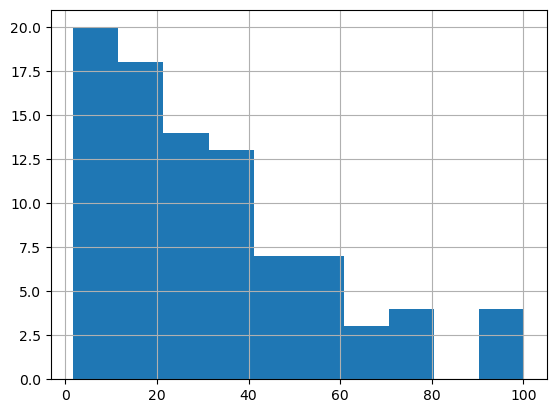

In [20]:
a = dataset.meta[dataset.meta['label'].isin(classes)].groupby(['filename','label'])
a = a.sum()
a['duration %'].hist()

In [21]:
a = dataset.meta[dataset.meta['label'].isin(classes)].groupby(['filename','label'])
a = a.sum().round()
a[a['duration %'] > 75]

start   end  duration %
filename                  label                                
1653409372_1653409432.wav cutting        23.0  70.0        79.0
1653514199_1653514259.wav truck_idling    0.0  60.0       100.0
1654261260_1654261320.wav truck_idling    0.0  60.0       100.0
1655826045_1655826105.wav truck_idling    0.0  60.0       100.0
1655826106_1655826166.wav truck_idling    0.0  60.0       100.0

In [22]:
for i in range(12):
    print(i, i * 5, i * 5 + 5)

0 0 5
1 5 10
2 10 15
3 15 20
4 20 25
5 25 30
6 30 35
7 35 40
8 40 45
9 45 50
10 50 55
11 55 60


In [23]:
dataset.__dict__.keys()

dict_keys(['file_paths', 'meta', 'labels', 'folder', 'categories'])

In [24]:
dataset[1]

(PosixPath('../../datasets/Vicente/Ubicación 2 Semana 1/1655596412_1655596472.wav'),
 181    wind
 182    wind
 183     dog
 184    bird
 185    bird
 186    bird
 187    bird
 188     dog
 189    bird
 190    rain
 191     dog
 192     dog
 Name: label, dtype: object)

In [25]:
dataset

In [26]:
vicente_df

alerts/bells  alerts/horns  alerts/siren  \
1653428341_1653428401.wav              0.0           0.0      0.166667   
1653460321_1653460381.wav              0.0           0.0      0.083333   
1653472020_1653472080.wav              0.0           0.0      0.083333   
1653626700_1653626760.wav              0.0           0.0      0.083333   
1653361511_1653361571.wav              0.0           0.0      0.166667   
...                                    ...           ...           ...   
1654270595_1654270655(1).wav           0.0           0.0      0.416667   
1654221272_1654221332(1).wav           0.0           0.0      0.000000   
1654228064_1654228124(1).wav           0.0           0.0      0.000000   
1654220421_1654220481.wav              0.0           0.0      0.000000   
1654225332_1654225392(1).wav           0.0           0.0      0.000000   

                              animal/bird  animal/dog  animal/others  \
1653428341_1653428401.wav             0.0    0.000000            0.0   
1653460321_1653460381.wav             0.0    0.000000            0.0   
1653472020_1653472080.wav             0.0    0.000000            0.0   
1653626700_1653626760.wav             0.0    0.083333            0.0   
1653361511_1653361571.wav             0.0    0.000000            0.0   
...                                   ...         ...            ...   
1654270595_1654270655(1).wav          0.0    0.000000            0.0   
1654221272_1654221332(1).wav          0.0    0.000000            0.0   
1654228064_1654228124(1).wav          0.0    0.000000            0.0   
1654220421_1654220481.wav             0.0    0.000000            0.0   
1654225332_1654225392(1).wav          0.0    0.583333            0.0   

                              environmental/others  environmental/rain  \
1653428341_1653428401.wav                      0.0                0.00   
1653460321_1653460381.wav                      0.0                0.00   
1653472020_1653472080.wav                      0.0                0.00   
1653626700_1653626760.wav                      0.0                0.00   
1653361511_1653361571.wav                      0.0                0.00   
...                                            ...                 ...   
1654270595_1654270655(1).wav                   0.0                0.00   
1654221272_1654221332(1).wav                   0.0                0.00   
1654228064_1654228124(1).wav                   0.0                0.25   
1654220421_1654220481.wav                      0.0                0.00   
1654225332_1654225392(1).wav                   0.0                0.00   

                              environmental/waves  environmental/wind  \
1653428341_1653428401.wav                     0.0                 0.0   
1653460321_1653460381.wav                     0.0                 0.0   
1653472020_1653472080.wav                     0.0                 0.0   
1653626700_1653626760.wav                     0.0                 0.0   
1653361511_1653361571.wav                     0.0                 0.0   
...                                           ...                 ...   
1654270595_1654270655(1).wav                  0.0                 0.0   
1654221272_1654221332(1).wav                  0.0                 0.0   
1654228064_1654228124(1).wav                  0.0                 0.0   
1654220421_1654220481.wav                     0.0                 0.0   
1654225332_1654225392(1).wav                  0.0                 0.0   

                              humans/others  mechanical/air_conditioner  \
1653428341_1653428401.wav          0.000000                    0.083333   
1653460321_1653460381.wav          0.083333                    0.000000   
1653472020_1653472080.wav          0.000000                    0.000000   
1653626700_1653626760.wav          0.000000                    0.000000   
1653361511_1653361571.wav          0.000000                    0.000000   
...                                     ...                 

In [27]:
summarized_result

[alerts/bells                  0.000000
 alerts/horns                  0.000000
 alerts/siren                  0.166667
 animal/bird                   0.000000
 animal/dog                    0.000000
 animal/others                 0.000000
 environmental/others          0.000000
 environmental/rain            0.000000
 environmental/waves           0.000000
 environmental/wind            0.000000
 humans/others                 0.000000
 mechanical/air_conditioner    0.083333
 mechanical/cutting            0.000000
 mechanical/digging            0.000000
 mechanical/explosives         0.000000
 mechanical/impact             0.000000
 mechanical/others             0.083333
 music/music                   0.000000
 vehicles/airborne             0.000000
 vehicles/others               0.000000
 dtype: float64,
 alerts/bells                  0.000000
 alerts/horns                  0.000000
 alerts/siren                  0.083333
 animal/bird                   0.000000
 animal/dog            

In [28]:
vicente_results['1655826045_1655826105.wav']

alerts/bells  alerts/horns  alerts/siren  animal/bird  animal/dog  \
0       0.000008      0.003023      0.074900     0.000038    0.000497   
1       0.000009      0.008715      0.227919     0.000067    0.000701   
2       0.000055      0.021411      0.443435     0.000073    0.000808   
3       0.000003      0.002664      0.103622     0.000077    0.000637   
4       0.000035      0.005274      0.088729     0.000100    0.000495   
5       0.000019      0.012053      0.187424     0.000096    0.000665   
6       0.000041      0.003829      0.140376     0.000149    0.000906   
7       0.000008      0.004130      0.219709     0.000172    0.001920   
8       0.000042      0.005677      0.139517     0.000092    0.000571   
9       0.000013      0.003532      0.107409     0.000072    0.000464   
10      0.000030      0.004490      0.126718     0.000066    0.000469   
11      0.000037      0.022252      0.450316     0.000164    0.001310   

    animal/others  environmental/others  environmental/rain  \
0        0.000370              0.000003            0.000180   
1        0.000526              0.000002            0.000132   
2        0.000447              0.000006            0.000400   
3        0.000612              0.000002            0.000090   
4        0.000878              0.000006            0.000570   
5        0.000638              0.000004            0.000238   
6        0.001142              0.000016            0.001000   
7        0.001269              0.000003            0.000197   
8        0.000535              0.000006            0.000516   
9        0.000547              0.000002            0.000133   
10       0.000456              0.000004            0.000421   
11       0.000906              0.000006            0.000453   

    environmental/waves  environmental/wind  humans/others  \
0              0.000020            0.002392       0.000116   
1              0.000050            0.015609       0.000118   
2              0.000049            0.012718       0.000210   
3              0.000018            0.003530       0.000129   
4              0.000101            0.006733       0.000143   
5              0.000044            0.007409       0.000145   
6              0.000245            0.016295       0.000369   
7              0.000056            0.015046       0.000333   
8              0.000125            0.008347       0.000190   
9              0.000038            0.004713       0.000084   
10             0.000064            0.007616       0.000092   
11             0.000115            0.032182       0.000293   

    mechanical/air_conditioner  mechanical/cutting  mechanical/digging  \
0                     0.174554            0.000003            0.000673   
1                     0.280656            0.000002            0.000631   
2                     0.107742            0.000005            0.001045   
3                     0.277581            0.000002            0.000543   
4                     0.192689            0.000011            0.001068   
5                     0.258607            0.000003            0.000991   
6                     0.208681            0.000015            0.001669   
7                     0.369445            0.000005            0.000514   
8                     0.262322            0.000009            0.001714   
9                     0.171305            0.000002            0.000577   
10                    0.227636            0.000004            0.000660   
11                    0.204211            0.000007            0.000723   

    mechanical/explosives  mechanical/impact  mechanical/others  music/music  \
0                0.000050           0.020381           0.722137     0.000453   
1                0.000062           0.023704           0.440136     0.000654   
2                0.000167           0.009628           0.400389     0.001117   
3                0.000031           0.030852           0.578999     0.000376   
4                0.000071           0.021006           0.680525 

In [29]:
import pickle

#with open('UrbanSound_ESC-PANN-tag.pkl', 'rb') as f:
with open('UrbanSound_ESC-PANN-tag-pink-noise-pretrained.pkl', 'rb') as f:
    vicente_results = pickle.load(f)

th = 0.6
summarized_result = []
for name, percentages in vicente_results.items():
        summarized_result.append((percentages > th).sum()/12)
print(summarized_result[0])


vicente_df = pd.DataFrame(summarized_result, index=list(vicente_results.keys()))
idx_duplicates = [idx for idx, repeated in (vicente_df.index.map(lambda x: ''.join(x.split('(1)'))).value_counts() > 1).items() if repeated]
vicente_df_noduplo = vicente_df.drop(idx_duplicates)
#display(vicente_df.head())
vicente_df_noduplo.describe().T

alerts/bells                  0.000000
alerts/horns                  0.000000
alerts/siren                  0.166667
animal/bird                   0.000000
animal/dog                    0.000000
animal/others                 0.000000
environmental/others          0.000000
environmental/rain            0.000000
environmental/waves           0.000000
environmental/wind            0.000000
humans/others                 0.000000
mechanical/air_conditioner    0.083333
mechanical/cutting            0.000000
mechanical/digging            0.000000
mechanical/explosives         0.000000
mechanical/impact             0.000000
mechanical/others             0.083333
music/music                   0.000000
vehicles/airborne             0.000000
vehicles/others               0.000000
dtype: float64


count      mean       std  min  25%  50%  \
alerts/bells                115.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/horns                115.0  0.000000  0.000000  0.0  0.0  0.0   
alerts/siren                115.0  0.042754  0.100174  0.0  0.0  0.0   
animal/bird                 115.0  0.000725  0.007771  0.0  0.0  0.0   
animal/dog                  115.0  0.092029  0.247397  0.0  0.0  0.0   
animal/others               115.0  0.000725  0.007771  0.0  0.0  0.0   
environmental/others        115.0  0.002174  0.017315  0.0  0.0  0.0   
environmental/rain          115.0  0.215217  0.329470  0.0  0.0  0.0   
environmental/waves         115.0  0.000000  0.000000  0.0  0.0  0.0   
environmental/wind          115.0  0.000000  0.000000  0.0  0.0  0.0   
humans/others               115.0  0.005072  0.020011  0.0  0.0  0.0   
mechanical/air_conditioner  115.0  0.002174  0.013341  0.0  0.0  0.0   
mechanical/cutting          115.0  0.000000  0.000000  0.0  0.0  0.0   
mechanical/digging          115.0  0.007971  0.085480  0.0  0.0  0.0   
mechanical/explosives       115.0  0.006522  0.033384  0.0  0.0  0.0   
mechanical/impact           115.0  0.002174  0.017315  0.0  0.0  0.0   
mechanical/others           115.0  0.046377  0.130223  0.0  0.0  0.0   
music/music                 115.0  0.001449  0.010941  0.0  0.0  0.0   
vehicles/airborne           115.0  0.001449  0.015542  0.0  0.0  0.0   
vehicles/others             115.0  0.000000  0.000000  0.0  0.0  0.0   

                                 75%       max  
alerts/bells                0.000000  0.000000  
alerts/horns                0.000000  0.000000  
alerts/siren                0.041667  0.500000  
animal/bird                 0.000000  0.083333  
animal/dog                  0.000000  1.000000  
animal/others               0.000000  0.083333  
environmental/others        0.000000  0.166667  
environmental/rain          0.333333  1.000000  
environmental/waves         0.000000  0.000000  
environmental/wind          0.000000  0.000000  
humans/others               0.000000  0.083333  
mechanical/air_conditioner  0.000000  0.083333  
mechanical/cutting          0.000000  0.000000  
mechanical/digging          0.000000  0.916667  
mechanical/explosives       0.000000  0.250000  
mechanical/impact           0.000000  0.166667  
mechanical/others           0.000000  0.666667  
music/music                 0.000000  0.083333  
vehicles/airborne           0.000000  0.166667  
vehicles/others             0.000000  0.000000

In [30]:
mask_rows = (vicente_df_noduplo.T > 0.75).any()
mask_cols = (vicente_df_noduplo > 0.75).any()
strong_ocurrence = vicente_df_noduplo.loc[mask_rows, mask_cols]

In [31]:
strong_ocurrence

animal/dog  environmental/rain  \
1653409372_1653409432.wav       0.000000            0.000000   
1655618019_1655618079.wav       0.000000            0.916667   
1655619957_1655620017.wav       0.000000            0.833333   
1655621595_1655621655.wav       0.000000            1.000000   
1655619897_1655619957.wav       0.000000            0.833333   
1655621474_1655621534.wav       0.000000            1.000000   
1655607019_1655607079.wav       0.000000            0.833333   
1655608595_1655608655.wav       0.000000            0.916667   
1655620139_1655620199.wav       0.000000            0.916667   
1655653356_1655653416.wav       0.000000            1.000000   
1655618625_1655618685.wav       0.000000            0.833333   
1655610597_1655610657.wav       0.000000            1.000000   
1655618443_1655618503.wav       0.000000            0.833333   
1655610839_1655610899.wav       0.000000            0.916667   
1655621534_1655621594.wav       0.000000            0.916667   
1655607261_1655607321.wav       0.000000            1.000000   
1654237499_1654237559(1).wav    0.916667            0.000000   
1654237378_1654237438(1).wav    0.916667            0.000000   
1654237560_1654237620.wav       0.833333            0.000000   
1654238106_1654238166(1).wav    0.916667            0.000000   
1654237257_1654237317(1).wav    0.833333            0.000000   
1654237985_1654238045(1).wav    1.000000            0.000000   
1654238045_1654238105(1).wav    0.916667            0.000000   

                              mechanical/digging  
1653409372_1653409432.wav               0.916667  
1655618019_1655618079.wav               0.000000  
1655619957_1655620017.wav               0.000000  
1655621595_1655621655.wav               0.000000  
1655619897_1655619957.wav               0.000000  
1655621474_1655621534.wav               0.000000  
1655607019_1655607079.wav               0.000000  
1655608595_1655608655.wav               0.000000  
1655620139_1655620199.wav               0.000000  
1655653356_1655653416.wav               0.000000  
1655618625_1655618685.wav               0.000000  
1655610597_1655610657.wav               0.000000  
1655618443_1655618503.wav               0.000000  
1655610839_1655610899.wav               0.000000  
1655621534_1655621594.wav               0.000000  
1655607261_1655607321.wav               0.000000  
1654237499_1654237559(1).wav            0.000000  
1654237378_1654237438(1).wav            0.000000  
1654237560_1654237620.wav               0.000000  
1654238106_1654238166(1).wav            0.000000  
1654237257_1654237317(1).wav            0.000000  
1654237985_1654238045(1).wav            0.000000  
1654238045_1654238105(1).wav            0.000000

In [32]:
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/digging'
display(strong_ocurrence.loc[mask_offensive_class])
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/air_conditioner'
display(strong_ocurrence.loc[mask_offensive_class])
mask_offensive_class = strong_ocurrence.idxmax(axis=1) == 'mechanical/others'
display(strong_ocurrence.loc[mask_offensive_class])

animal/dog  environmental/rain  mechanical/digging
1653409372_1653409432.wav         0.0                 0.0            0.916667

Empty DataFrame
Columns: [animal/dog, environmental/rain, mechanical/digging]
Index: []

Empty DataFrame
Columns: [animal/dog, environmental/rain, mechanical/digging]
Index: []

In [33]:
path

PosixPath('../../datasets/Vicente/Ubicación 2 Semana 1/1655609019_1655609079.wav')

In [36]:
np.arange(preds.shape[0]+1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [37]:
preds

alerts/bells  alerts/horns  alerts/siren  animal/bird  animal/dog  \
0       0.001739      0.024087      0.067021     0.000714    0.018787   
1       0.000389      0.012641      0.022460     0.000369    0.008013   
2       0.002636      0.014094      0.050060     0.000432    0.017884   
3       0.002249      0.053246      0.104546     0.000876    0.017995   
4       0.000800      0.014137      0.047580     0.000240    0.005911   
5       0.000765      0.003687      0.014950     0.000140    0.002587   
6       0.000226      0.003970      0.004982     0.000035    0.001580   
7       0.001434      0.009884      0.062837     0.000152    0.005307   
8       0.000733      0.010259      0.059463     0.000443    0.009047   
9       0.000707      0.034865      0.125631     0.000608    0.017239   
10      0.000926      0.032085      0.154684     0.000950    0.019102   
11      0.000835      0.034469      0.110274     0.000304    0.007964   

    animal/others  environmental/others  environmental/rain  \
0        0.006757              0.026296            0.188245   
1        0.002713              0.104807            0.365085   
2        0.011163              0.058745            0.295327   
3        0.014841              0.027292            0.121988   
4        0.005212              0.009090            0.394252   
5        0.002236              0.005365            0.807639   
6        0.000462              0.007236            0.906965   
7        0.005596              0.023871            0.646089   
8        0.004788              0.004251            0.386086   
9        0.013596              0.012817            0.067521   
10       0.012572              0.021489            0.186197   
11       0.005016              0.012625            0.237096   

    environmental/waves  environmental/wind  humans/others  \
0              0.000555            0.001497       0.040795   
1              0.000259            0.000889       0.019821   
2              0.000776            0.003681       0.051646   
3              0.000554            0.002106       0.060417   
4              0.000386            0.001506       0.024156   
5              0.000612            0.000953       0.011558   
6              0.000114            0.000545       0.002020   
7              0.000560            0.002506       0.037963   
8              0.000709            0.000846       0.026239   
9              0.000248            0.002589       0.052108   
10             0.000370            0.002515       0.052494   
11             0.000244            0.001014       0.030537   

    mechanical/air_conditioner  mechanical/cutting  mechanical/digging  \
0                     0.154994            0.009369            0.062832   
1                     0.169209            0.003851            0.052280   
2                     0.101329            0.007424            0.044546   
3                     0.100446            0.007771            0.083235   
4                     0.067987            0.001699            0.021491   
5                     0.033396            0.001672            0.006825   
6                     0.022329            0.000195            0.001618   
7                     0.041934            0.002926            0.011979   
8                     0.089557            0.003308            0.028325   
9                     0.251343            0.001619            0.035875   
10                    0.223850            0.005298            0.058021   
11                    0.164739            0.001617            0.036476   

    mechanical/explosives  mechanical/impact  mechanical/others  music/music  \
0                0.015770           0.032671           0.254016     0.092431   
1                0.004959           0.033232           0.146110     0.052372   
2                0.010215           0.010878           0.210049     0.106708   
3                0.016479           0.034611           0.151800     0.197156   
4                0.005310           0.012768           0.359591 

In [38]:
np.arange(preds.shape[0]+1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

filename      start        end label station   labeller
111  1655609019_1655609079.wav   0.000000  60.066666  rain   capta  Esteban_G
112  1655609019_1655609079.wav   0.000000  60.066666  rain   capta  Esteban_G
113  1655609019_1655609079.wav  13.366667  14.300000   dog   capta  Esteban_G
114  1655609019_1655609079.wav  18.193333  21.060000   dog   capta  Esteban_G
115  1655609019_1655609079.wav  25.580000  28.893333   dog   capta  Esteban_G

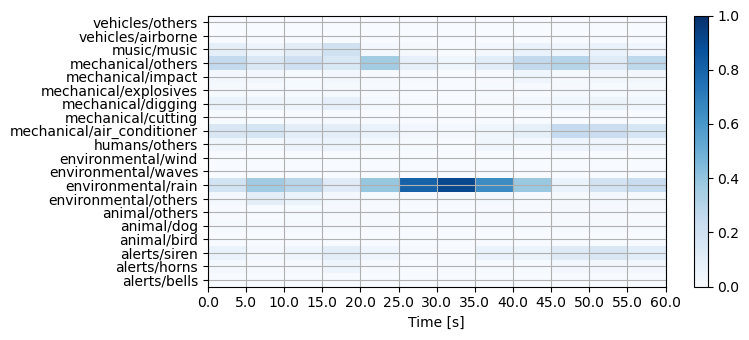

In [34]:
dataset = Vicente(categories=vicente_df.columns)
path, _ = dataset[vicente_df.index.get_loc('1653306233_1653306293.wav')] # mechanical-other
#path, _ = dataset[vicente_df.index.get_loc('1653409372_1653409432.wav')] # digging/cutting
#path, _ = dataset[vicente_df.index.get_loc('1654224726_1654224786(1).wav')]
#path, _ = dataset[vicente_df.index.get_loc('1654286174_1654286234(1).wav')] #dog
#path, _ = dataset[102]

meta = dataset.match_ids(path)
display(meta)

#window_size = 32000*5
#preds = []
#with torch.no_grad():
#    for i in range(sample['waveform'].shape[-1]//window_size):
#        preds_ = torch.nn.Softmax(dim=-1)(model({'waveform': sample['waveform'][:, i*window_size:(i+1)*window_size].unsqueeze(0)})).detach()
#        preds.append(preds_.numpy())
#preds = np.stack(preds)[:, 0, :]

preds = vicente_results[path.name]
fig, ax = plt.subplots(figsize=(8, 3.5), tight_layout=True)
img = ax.pcolormesh(preds.T, vmin=0, vmax=1, cmap=plt.cm.Blues)
plt.colorbar(img)
ax.set_xticks(np.arange(preds.shape[0]+1))
ax.set_xticklabels(np.linspace(0, 60, num=preds.shape[0]+1))
ax.set_yticks(np.arange(len(vicente_df.columns))+0.5)
ax.set_yticklabels(vicente_df.columns);
ax.set_xlabel('Time [s]')
ax.grid()
#plt.savefig('non-compliant3.pdf')

waveform, rate = torchaudio.load(path)
Audio(data=waveform[0].numpy(), rate=rate)